## Population vector analyses

In [2]:
import sys
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
sys.path.append('..') # for relative import in jupyter notebook
from fileio.loadphy import as_pynapple

### Load spiking data

In [3]:
phy_dir = '../../TestData/phy/'
spks = as_pynapple(phy_dir)
print(spks)

  Index    rate  type      peak_chan    x_pos    y_pos
-------  ------  ------  -----------  -------  -------
      0    1.39  SU               78       11      780
      1    1.74  SU               85       59      840
      2    1.17  SU               86       11      860
      3    3.28  SU               87       43      860
      4    2.33  SU               94       11      940
      5    1.34  SU               97       59      960
      6    1.86  SU              105       59     1040
      7    2.62  SU              109       59     1080
      8    7.49  SU              118       11     1180
      9    3.42  SU              118       11     1180
     10    5.63  SU              121       59     1200
     11    7.6   SU              126       11     1260
     12    6.82  SU              137       59     1360
     13    2.9   SU              142       11     1420
     14    3.75  SU              122       11     1220


### Bin spiking activity

In [4]:
bin_size = 0.1 # in seconds, so 100ms
spks_bin = spks.count(0.1)

In [4]:
def ztrans(data, axis=0):
    zdata = (data-np.mean(data,axis=0))/np.std(data,axis=0)
    return zdata

spks_bin_z = ztrans(spks_bin)

<AxesSubplot: xlabel='Time (s)', ylabel='Unit ID'>

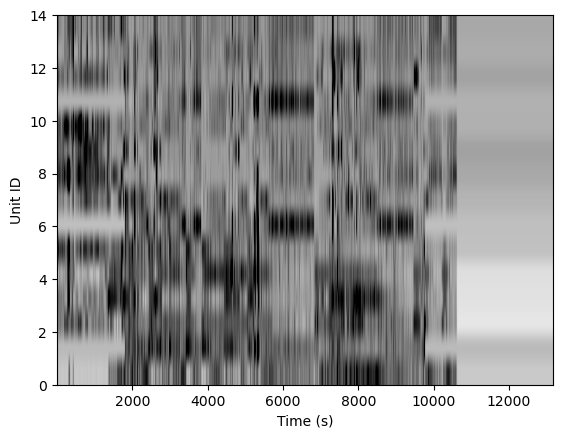

In [5]:
def popplot(data, ax=None, tlim=None):
    if ax is None:
        fig, ax = plt.subplots()

    bin_times = data.index.values
    bin_ids = data.columns.values
    bin_np = data.values.T
    ax.imshow(bin_np,vmin=-1,vmax=1,interpolation='antialiased',cmap='binary',
              extent=(bin_times[0], bin_times[-1],bin_ids[0], bin_ids[-1]))
    if tlim is not None:
        ax.set_xlim(tlim)
    ax.set_aspect('auto')
    ax.set_xlabel(data.index.name)
    ax.set_ylabel('Unit ID')
    return ax

popplot(spks_bin_z)

Notice that the spiking activity ceases around 10,000 seconds into the recording, probably due to a disconnection. Let's regenerate our binned spiking array restricted to the period when spiking was present.

Last spike was fired at 10604.96 seconds


<AxesSubplot: xlabel='Time (s)', ylabel='Unit ID'>

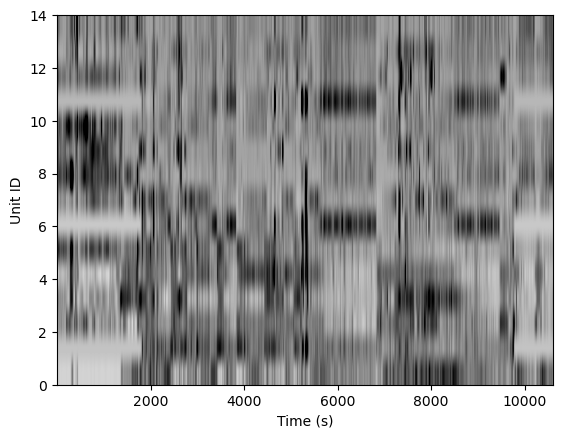

In [6]:
# get the time of the last spike across all units
last_spk = np.max([x.index.values[-1] for x in spks.values()])
print("Last spike was fired at {} seconds".format(round(last_spk,2)))

# create pynapple segment for restricting binning
spk_seg = nap.IntervalSet(0,last_spk)
spks_bin = spks.restrict(spk_seg).count(bin_size)
spks_bin_z = ztrans(spks_bin)

# now let's plot to make sure we removed the spike-free portion
popplot(spks_bin_z)

The activity appears nonstationary, meaning that the statistical properties of the spiking changes with time. This is evident in period where subsets of neurons are activated and then go silent, replaced by a different subset. We can look within some of these periods to see the types of activity patterns present.

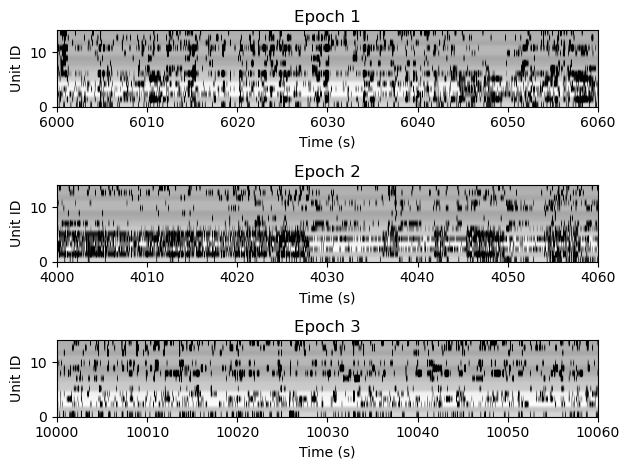

In [7]:
fig, ax = plt.subplots(3)
popplot(spks_bin_z,ax=ax[0],tlim=[6000, 6060])
ax[0].set_title('Epoch 1')
popplot(spks_bin_z,ax=ax[1],tlim=[4000, 4060])
ax[1].set_title('Epoch 2')
popplot(spks_bin_z,ax=ax[2],tlim=[10000, 10060])
ax[2].set_title('Epoch 3')
fig.tight_layout()

### Traditional principal component analysis of population activity

A common technique to reduce the dimensionality of population vectors is principal component analysis (PCA). PCA ...
THEN TALK ABOUT HOW PCA AND SVD ARE RELATED

In [1]:
# SVD on population activity
U,S,V = svd(spks_bin_z.values[::10,:].T)

NameError: name 'svd' is not defined

In [49]:
def isi_plot(spk_grp, id):
    isi_bins = np.logspace(-4,1,100,base=10)
    hist_data = np.histogram(np.diff(spk_grp[id].index.values),isi_bins)

    # find the time when more than 0.5% of ISIs remain
    cutoff = isi_bins[np.nonzero((np.cumsum(hist_data[0])/np.sum(hist_data[0]))>0.05)[0][0]]
    fig, ax = plt.subplots()
    ax.plot(isi_bins[1:],hist_data[0])
    ax.set_xscale('log')
    ax.axvline(cutoff,color='r')
    plt.show()
    

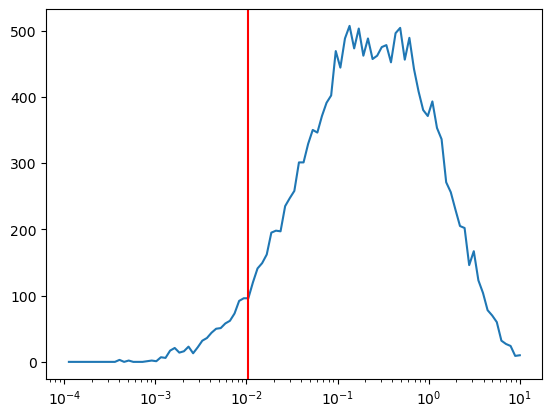

In [66]:
isi_plot(spk_grp,0)

In [122]:
def refract_fp(spks):
    refract = 0.003
    num_spks = spks.size
    dur = spks[-1]-spks[0]
    viol_count = np.sum(np.diff(spks)<=refract)
    refract_time = 2*refract*num_spks
    spk_rate = num_spks/dur
    viol_rate = viol_count/refract_time
    r_fp = viol_rate/spk_rate
    return r_fp

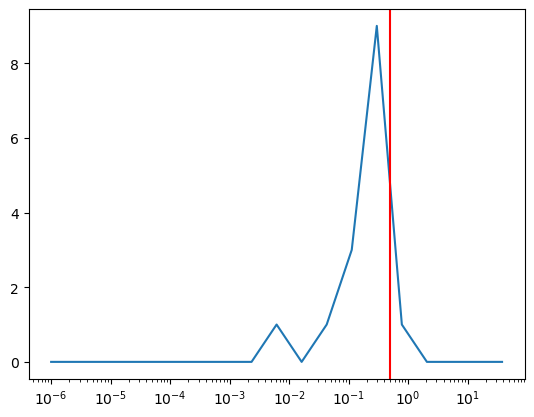

In [150]:
r_fp = pd.Series(None, index=clu_id_list, name='isi_fp',dtype='float64')
r_fp.index.name = 'clu_id'

for id in clu_id_list:
    r_fp.loc[id] = refract_fp(spk_grp[id].times())

r_fp_hist = np.histogram(r_fp.values,np.logspace(-6,2,20))
fig, ax = plt.subplots()
ax.plot(r_fp_hist[1][:-1], r_fp_hist[0])
ax.set_xscale('log')
ax.axvline(0.5,color='r')
plt.show()